<a href="https://colab.research.google.com/github/cassales/Hackathon2024Bootcamp/blob/master/Sample_Image_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Writing an image classifier in Keras is surprisingly simple. we can write a classifier in under 20 lines of code (not inclusive of data processing and visualization)
As usual, we start by importing the important libraries

In [ ]:
import keras
import os
os.environ["KERAS_BACKEND"] = "torch"

In the next block we are using the predefined function to load in the data, if you have your own images, you can instead use the following code to load in your own data. The code expects the following directory structure, so you  would need to follow that directory structure.
```
> train
> > class_1
> > > image_1
> > > image_2
> > > image_3
...
> > class_2
> > > image_1
> > > image_2
...
...
> val
> > class_1
> > > image_1
> > > image_2
...
> > class_2
> > > image_1
...
```
You can use the following code instead to load your images
```
batch_size=256
train_ds=keras.preprocessing.image_dataset_from_directory('./train',batch_size=batch_size, label_mode='categorical')
val_ds=keras.preprocessing.image_dataset_from_directory('./val',batch_size=batch_size,shuffle=False,label_mode='categorical')
```



In [ ]:
cifar100 = keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()

This block is optional, this block visualizes the first 100 images in the training set, and define human readible labels for the image

In [ ]:
class_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
                'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
                'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
                'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
                'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
                'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
                'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
                'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
                'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
                'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


<ipython-input-36-bff66ea7b3d4>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_labels[int(Y_train[i])])


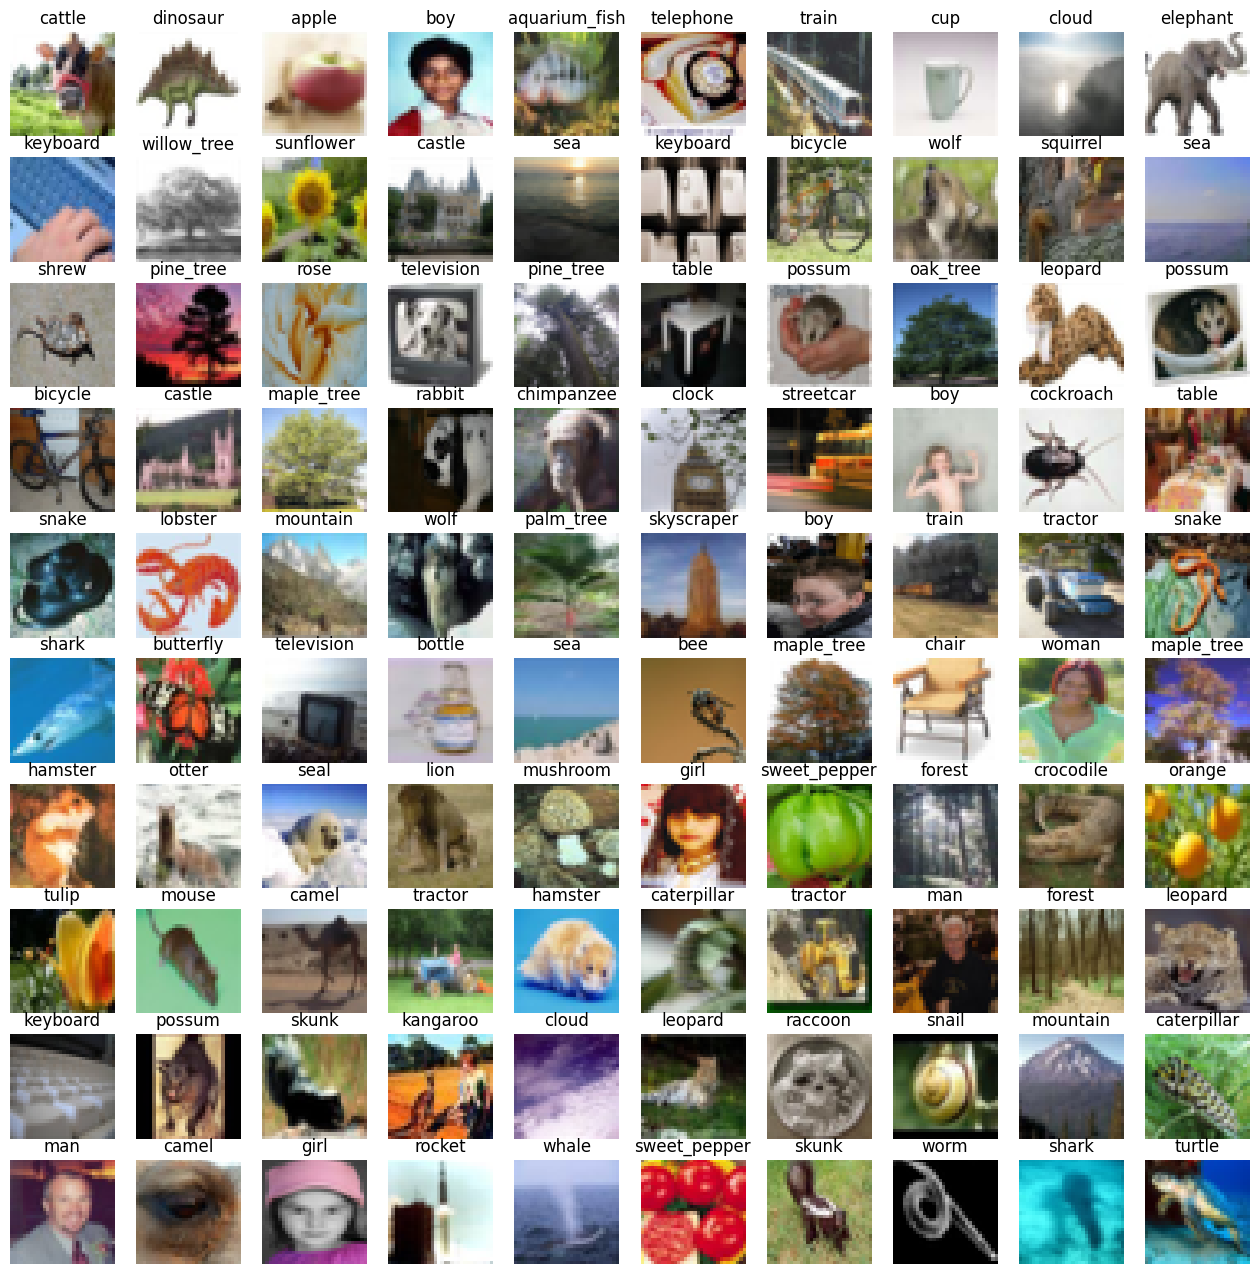

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,16))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i], cmap = 'gray')
  plt.title(class_labels[int(Y_train[i])])

In the next block we define the model. The method we are using here is known as transfer learning. We are using a pretrained model, and adapting it for our dataset. You can choose the pretrained network from any model in keras.applications, important things to note here is to set the number of classes to the number of classes in the dataset (here CIFAR100 has 100 different classes) and to set the input_shape to the size of the image. (here our images are 32 x 32, and we have 3 channels (RGB)). The rest of the code pretty much stays the same, however you may experiment with the architecture by adding more layers.

In [ ]:
no_classes=100
base_model= keras.applications.DenseNet121(input_shape=(32,32,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model = keras.models.clone_model(base_model)
pretrained_model.set_weights(base_model.get_weights())
for layers in pretrained_model.layers:
    layers.trainable=False
x=pretrained_model.output
x=keras.layers.Dropout(0.25)(x)
predictor_head=keras.layers.Dense(no_classes,activation='softmax')(x)
model=keras.Model(inputs=pretrained_model.input, outputs=predictor_head)


The next block defines the training loop, we first do 10 epochs of training with all the layers frozen at a larger learning rate. We then fine tune the inner layers by unfreezing the inner layers and then learn at a much smaller learning rate (typically 1/10th the original learning rate).

In [ ]:
opt=keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_857          │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 38, 38, 3)      │              0 │ keras_tensor_857[0][0] │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 8, 8, 64)       │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 8, 8, 64)       │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 128)      │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 128)      │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 128)      │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 32)       │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 8, 8, 96)       │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 21,085,422 (80.43 MB)

 Trainable params: 6,972,708 (26.60 MB)

 Non-trainable params: 167,296 (653.50 KB)

 Optimizer params: 13,945,418 (53.20 MB)

In [ ]:
history_pretrain=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10, batch_size=256)
for layer in model.layers:
    if not isinstance(layer,keras.layers.BatchNormalization):
        layer.trainable = True
opt=keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_finetune=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=20, batch_size=256)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.0458 - loss: 16.4655 - val_accuracy: 0.1898 - val_loss: 5.4354
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1383 - loss: 7.5635 - val_accuracy: 0.2389 - val_loss: 4.1166
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1843 - loss: 5.2695 - val_accuracy: 0.2339 - val_loss: 3.8144
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2082 - loss: 4.3012 - val_accuracy: 0.2642 - val_loss: 3.4690
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.2286 - loss: 3.7921 - val_accuracy: 0.2689 - val_loss: 3.3365
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.2437 - loss: 3.5944 - val_accuracy: 0.2597 - val_loss: 3.2940
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2466 - loss: 3.4920 - val_accuracy: 0.2556 - val_loss: 3.3298
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2482 - loss: 3.4249 - val_a

Considering the size of the  images, and the number of classes ~55% accuracy in the unseen data isn't too shabby

<Axes: >

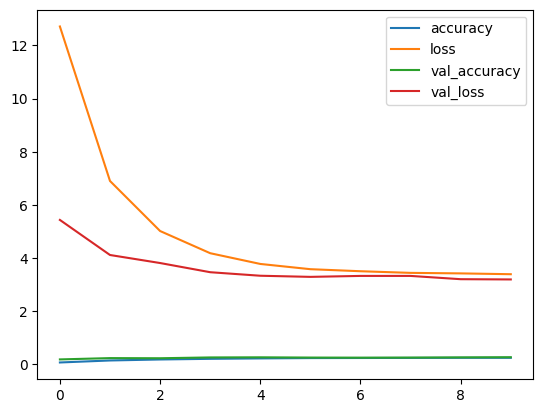

In [ ]:
import pandas as pd
pd.DataFrame(history_pretrain.history).plot()

In [ ]:
y_pred=model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step


In [ ]:
model.save('my_cifar100.keras')

In [ ]:
model_2=keras.models.load_model('my_cifar100.keras')

In [ ]:
import numpy as np
y_pred_label=np.argmax(y_pred,axis=1)


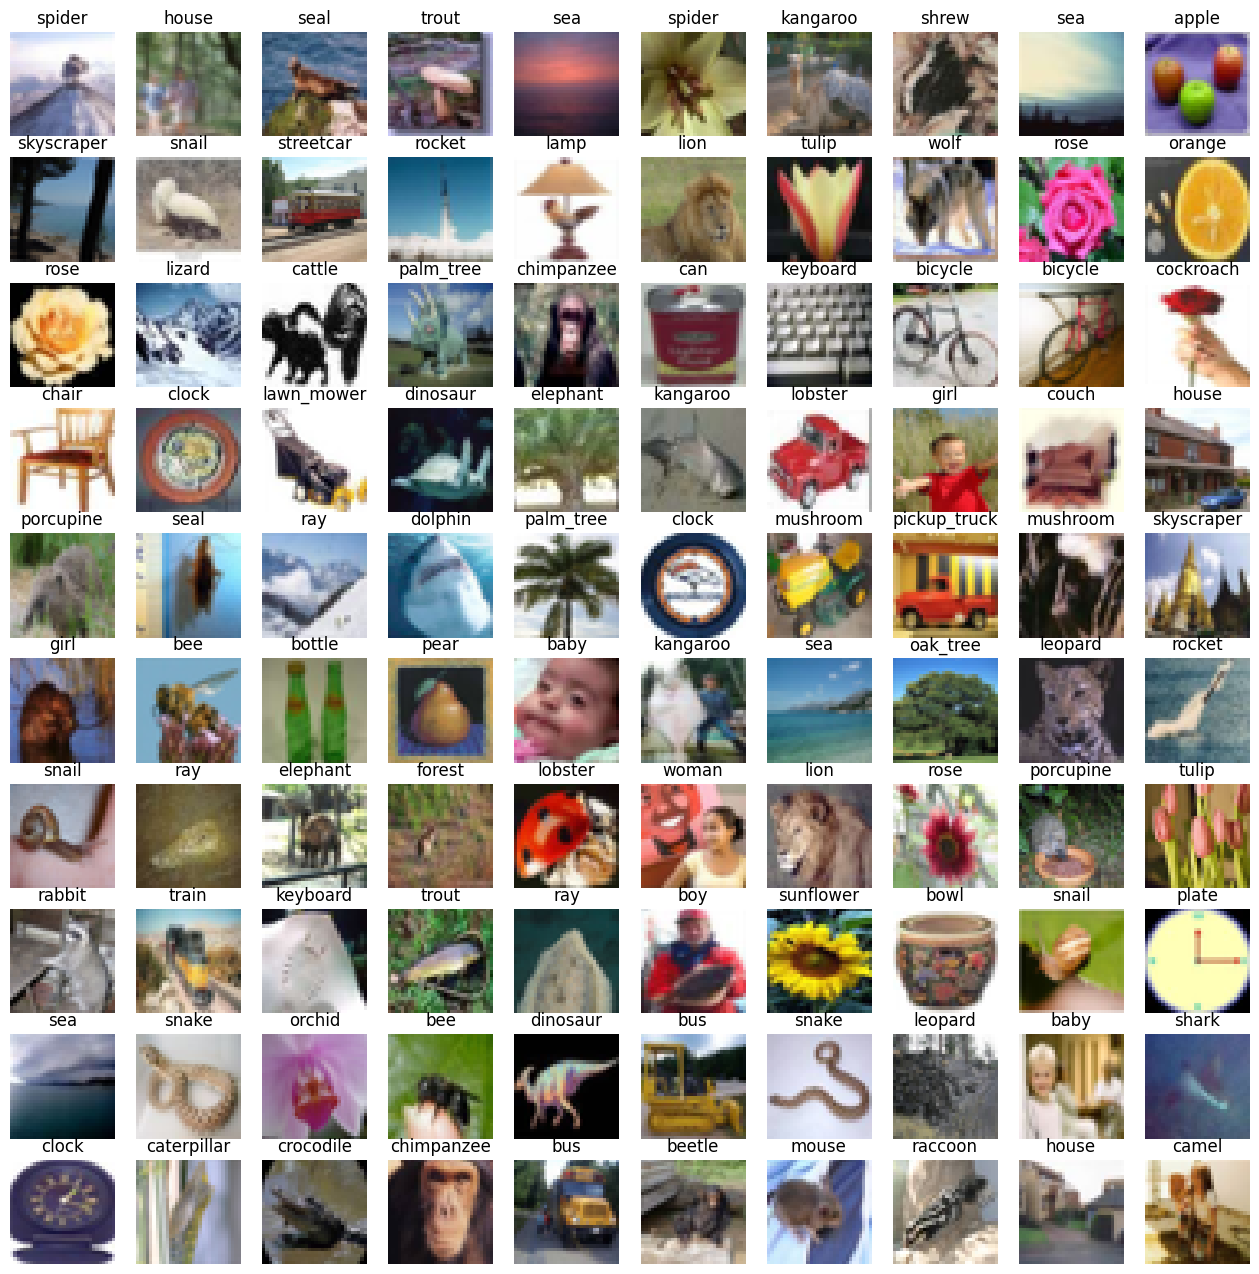

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,16))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_test[i], cmap = 'gray')
  plt.title(class_labels[y_pred_label[i]])


In [ ]:
model_2=keras.models.load_model('my_cifar100.keras')

In [ ]:
def plot_misprediction_simple(best_model,X_test,y_test):
    fig=plt.figure(figsize=(20,80))
    for i in range(100):
      X_test_filtered=X_test[y_test.squeeze()==i,:,:,:]
      y_pred=best_model.predict(X_test_filtered)
      (example_idx,class_idx)=np.unravel_index(np.argmax(np.array([y_pred[idx,:]-y_pred[idx,i] for idx in range(100)])),y_pred.shape)
      ax=plt.subplot(20,5,i+1)
      ax.imshow(X_test_filtered[example_idx],interpolation='nearest')
      plt.title(f'{class_labels[i]}: {y_pred[example_idx][i]:.3f}\n{class_labels[class_idx]}: {y_pred[example_idx][class_idx]:.3f}')
      plt.axis('off')
      plt.subplots_adjust(wspace=0.1,hspace=0.5)
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━

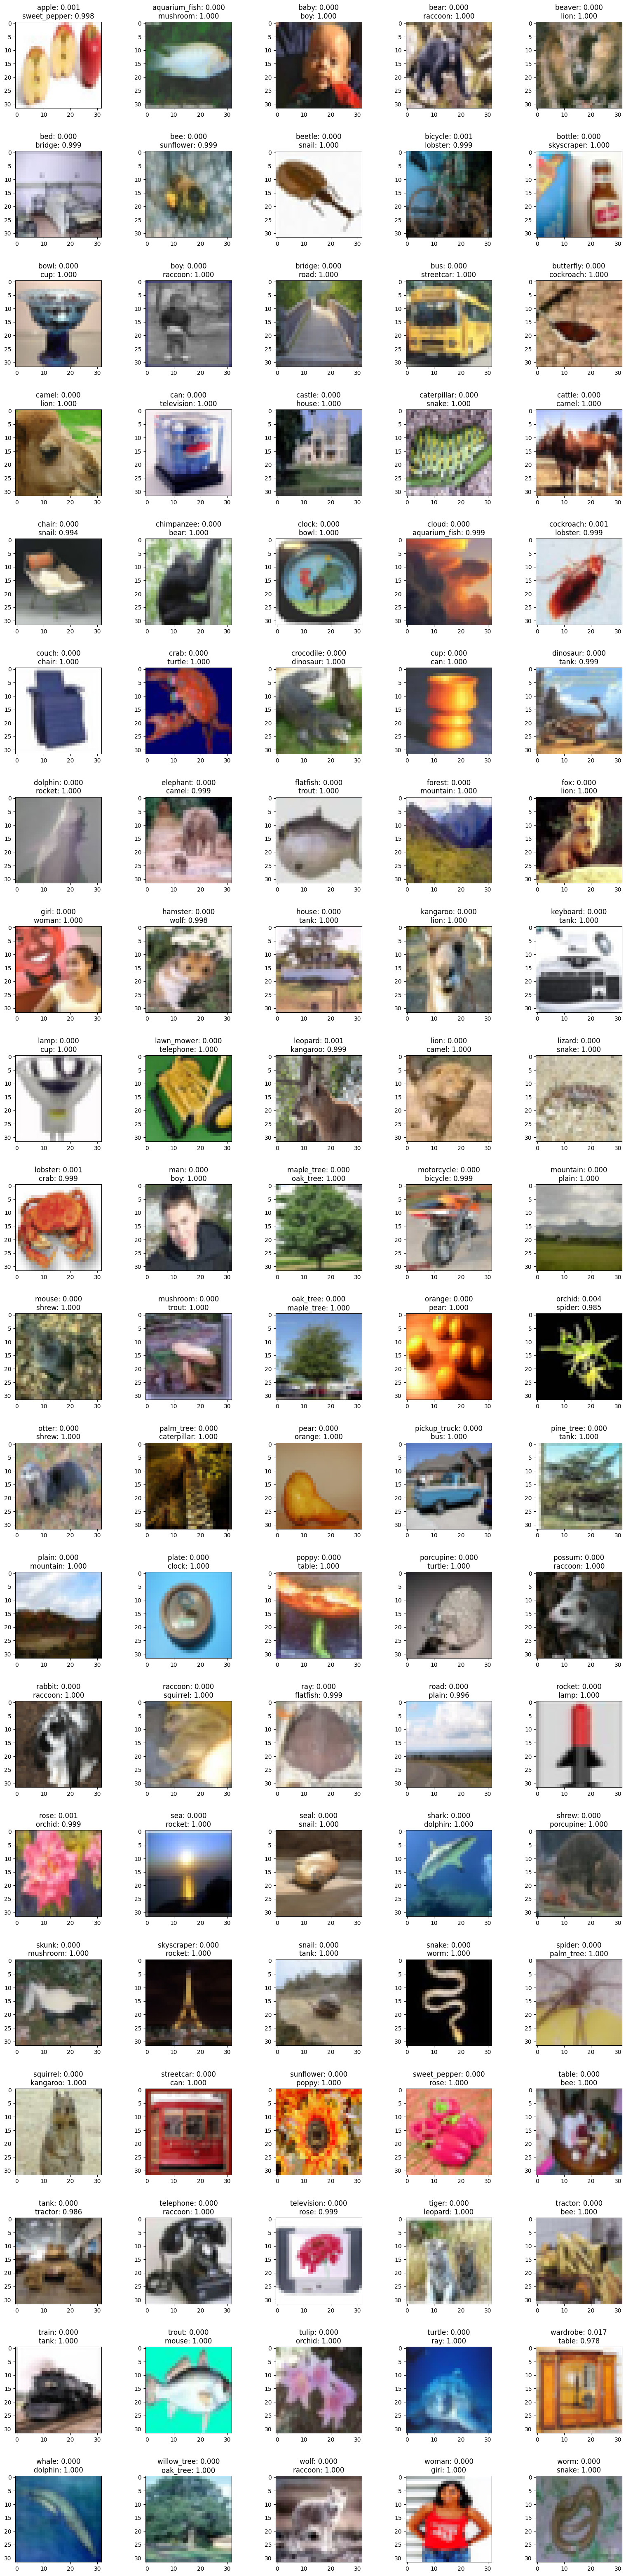

In [ ]:
plot_misprediction_simple(model_2,X_test,Y_test)